In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from astropy.io import fits
import pickle

In [2]:
flat_list = np.genfromtxt("./flat.list", dtype=str)
print(flat_list)

['AF702461.fits' 'AF702462.fits' 'AF702463.fits' 'AF702464.fits'
 'AF702465.fits' 'AF702466.fits' 'AF702467.fits' 'AF702468.fits'
 'AF702469.fits' 'AF702470.fits' 'AF702471.fits' 'AF702472.fits'
 'AF702473.fits' 'AF702474.fits' 'AF702475.fits' 'AF702476.fits'
 'AF702477.fits' 'AF702478.fits' 'AF702479.fits' 'AF702480.fits'
 'AF702481.fits' 'AF702482.fits' 'AF702483.fits' 'AF702484.fits'
 'AF702485.fits' 'AF702486.fits' 'AF702487.fits' 'AF702488.fits'
 'AF702489.fits' 'AF702490.fits']


In [3]:
median_bias = pickle.load(open("../bias/median_bias.p", "rb"))

In [4]:
bias_std = 1.9 #photoelectrons
readout_noise = 7.6 #photoelectrons

In [5]:
flat_fits = fits.open(flat_list[0])
flat_hdu = flat_fits[0]
gain = flat_hdu.header['GAIN']
readout_noise = flat_hdu.header['RDNOISE']
print(gain)
print(readout_noise)

1.91
7.1


<IPython.core.display.Javascript object>


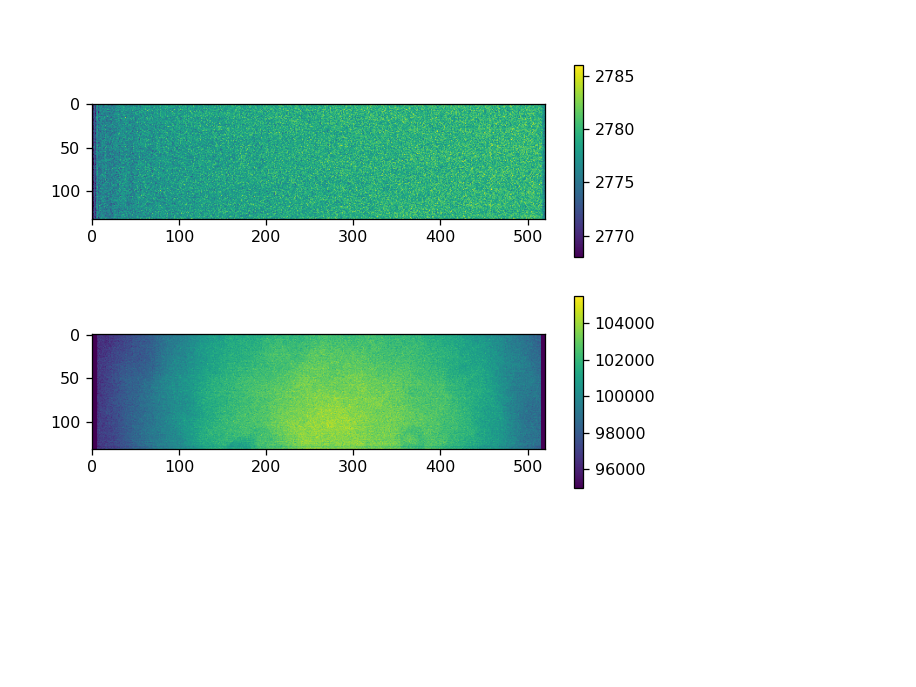

In [6]:
fig, ax = plt.subplots(2,1)
im1 = ax[0].imshow(median_bias, vmin=2768,vmax=2786)
im2 = ax[1].imshow(flat_hdu.data * gain, vmin=9.5e4,vmax=10.55e4)
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

In [7]:
n_images = len(flat_list)
x_shape, y_shape = np.shape(flat_hdu.data)

stack = np.empty([n_images, x_shape, y_shape])

for i_flat, flat_name in enumerate(flat_list):
    flat_temp = fits.open(flat_name)
    stack[i_flat, :, :] = flat_temp[0].data * gain - median_bias
    flat_temp.close()


In [8]:
print(stack)

[[[243.525 249.255 258.805 ...  47.75   34.38   21.01 ]
  [ 17.19    3.82    7.64  ...  34.38   30.56   25.785]
  [  4.775  -5.73   11.46  ...  52.525  16.235  22.92 ]
  ...
  [  0.955  -3.82    3.82  ...  41.065   7.64   24.83 ]
  [  3.82    7.64   -4.775 ...  33.425  22.92   13.37 ]
  [ -3.82    5.73  -13.37  ...  34.38   22.92   13.37 ]]

 [[247.345 285.545 233.975 ...  57.3    32.47   26.74 ]
  [  0.      3.82    1.91  ...  45.84   24.83   14.325]
  [ 23.875  13.37    9.55  ...  48.705  20.055  13.37 ]
  ...
  [ -2.865   3.82   -7.64  ...  29.605  11.46   17.19 ]
  [  3.82   -5.73   -0.955 ...  29.605  28.65   19.1  ]
  [ 13.37   -7.64   -3.82  ...  42.02   17.19   11.46 ]]

 [[272.175 241.615 243.525 ...  64.94   38.2    40.11 ]
  [ 17.19    3.82    9.55  ...  51.57   38.2    21.965]
  [  2.865   3.82    5.73  ...  50.615  20.055  19.1  ]
  ...
  [  2.865   0.      1.91  ...  31.515  21.01   30.56 ]
  [-17.19   -1.91  -20.055 ...  37.245  24.83    7.64 ]
  [ -1.91   -1.91   -7.64 

In [9]:
stack_med = np.empty(n_images)

for i_flat in range(0,n_images):
    stack_med[i_flat] = np.median(stack[i_flat,50:120,100:500]) #for a section in the center of the CCD.
    
print(stack_med)

[ 99679.08   100750.59   100232.5025 101273.93   100454.54   101073.8575
  99984.68   101016.5575 100133.66   101007.485  100159.9225 101142.14
 100173.77   101156.9425 100226.295  101143.095  100336.12   101569.98
 100718.12   101251.01   100246.35   101174.61   100348.535  101121.13
 100766.825  101743.79   100810.755  101758.115  100891.93   101804.91  ]


<IPython.core.display.Javascript object>


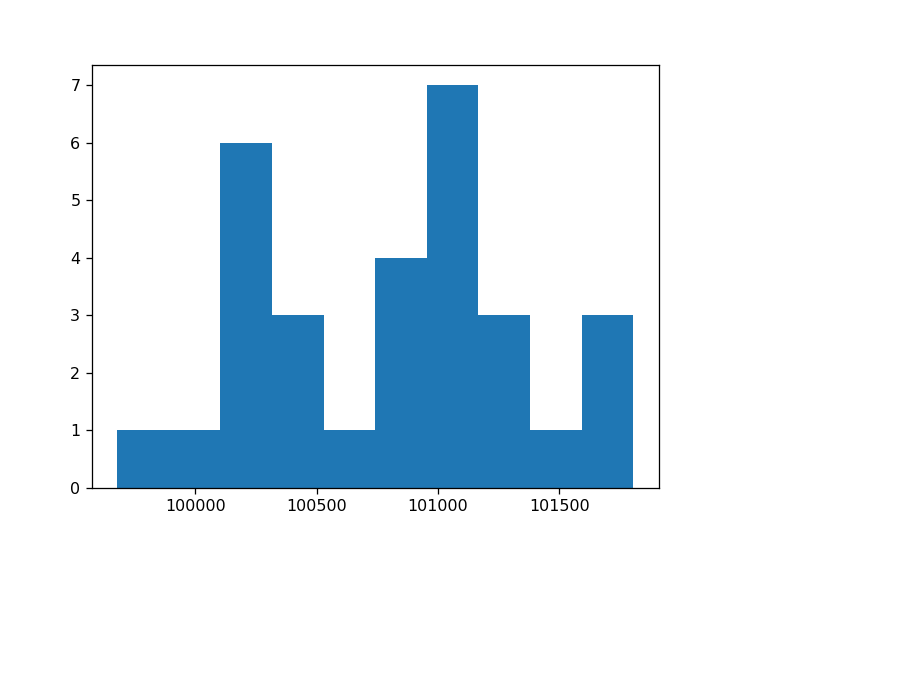

In [10]:
plt.figure()
plt.hist(stack_med)
plt.show()
#The difference in counts between the flat frame with higher and lower median values is
#potentially related to a not properly stabilized lamp.
#This happens for observations before 2016.

In [11]:
#In order to fix the stabilization problem, we will normalize each flat.
id_min = np.argmin(stack_med)
id_max = np.argmax(stack_med)
print("Frame with lowest value of the median: ", id_min)
print("Frame with highest value of the median: ", id_max)

Frame with lowest value of the median:  0
Frame with highest value of the median:  29


<IPython.core.display.Javascript object>


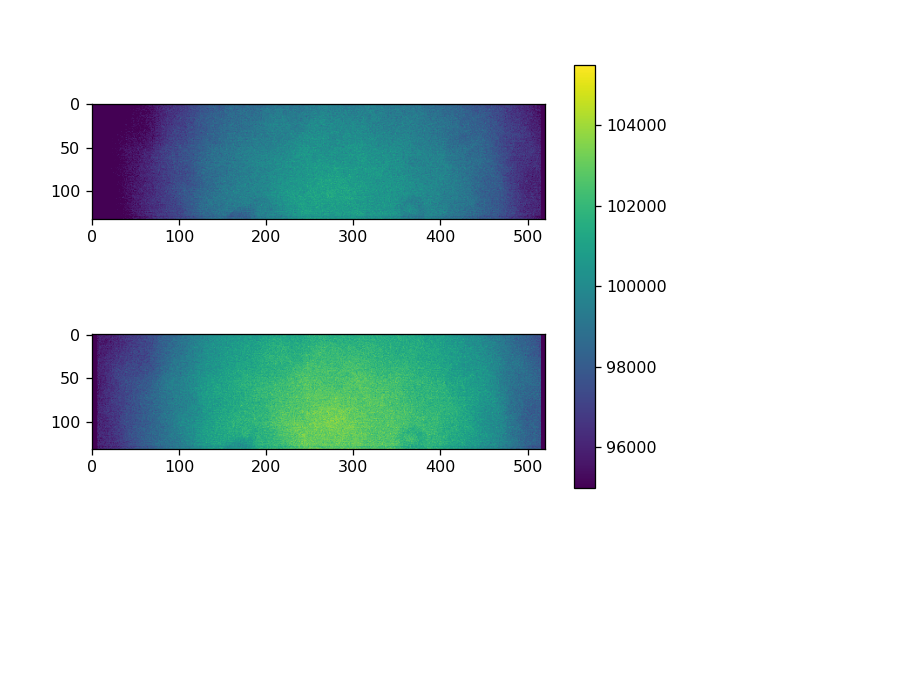

In [12]:
fig, ax = plt.subplots(2,1)
im1 = ax[0].imshow(stack[id_min,:,:], vmin=9.5e4,vmax=10.55e4)
im2 = ax[1].imshow(stack[id_max,:,:], vmin=9.5e4,vmax=10.55e4)
fig.colorbar(im1, ax=ax)

In [13]:
#Computing the error of the normalized median flat:
n_images = len(flat_list)
x_shape, y_shape = np.shape(flat_hdu.data)

print(np.shape(flat_hdu.data))

stack = np.empty([n_images, x_shape, y_shape])
stack_err = np.empty([n_images, x_shape, y_shape])

for i_flat, flat_name in enumerate(flat_list):
    flat_temp = fits.open(flat_name)
    flat_data_temp = flat_temp[0].data * gain - median_bias
    flat_data_median = np.median(flat_data_temp[50:120,100:500])
    stack[i_flat,:,:] = flat_data_temp / flat_data_median
    
    stack_err[i_flat,:,:] = np.sqrt(bias_std**2 + readout_noise**2 + flat_data_temp[:,:]) / flat_data_median
    #The error on flat_data_median is not considered as it is negligible.
    flat_temp.close()

(132, 521)


In [14]:
median_flat = np.median(stack, axis=0)
median_flat_err = np.sqrt(np.sum(stack_err**2, axis=0) / n_images)

In [15]:
pickle.dump(median_flat, open("median_flat.b", "wb"))
pickle.dump(median_flat_err, open("median_flat_err.b", "wb"))

In [16]:
n_images = len(flat_list)
x_shape, y_shape = np.shape(flat_hdu.data)

print(np.shape(flat_hdu.data))

stack_TEMP = np.empty([n_images, x_shape, y_shape])

for i_flat, flat_name in enumerate(flat_list):
    flat_temp = fits.open(flat_name)
    flat_data_temp = flat_temp[0].data * gain - median_bias
    flat_data_median = np.median(flat_data_temp[50:120,100:500])
    stack_TEMP[i_flat,:,:] = flat_data_temp 
    flat_temp.close()

(132, 521)


<IPython.core.display.Javascript object>


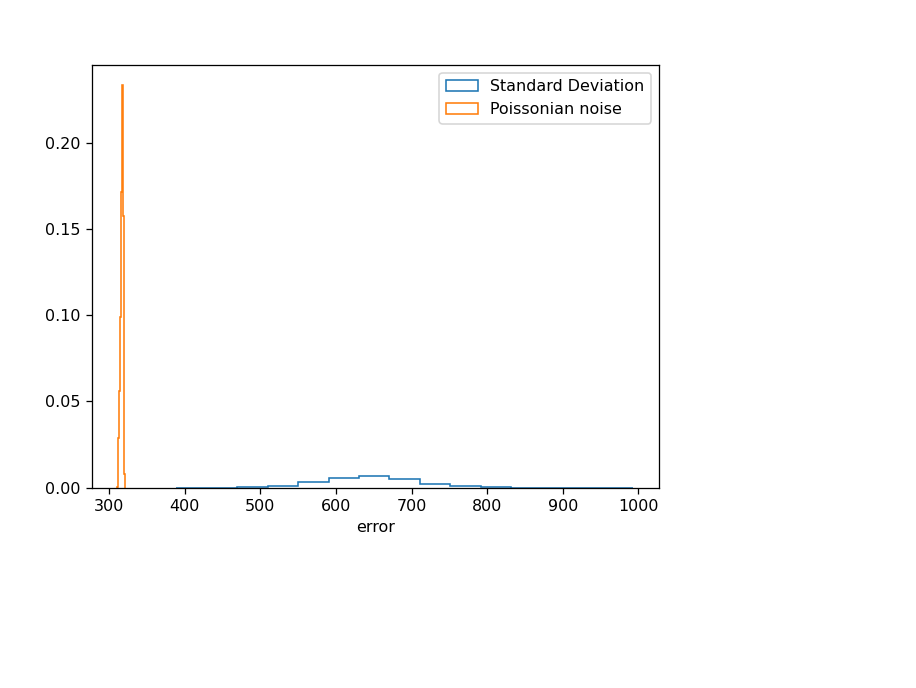

In [17]:
#Plotting the std pixel by pixel:
STD_pixel = np.std(stack_TEMP, axis=0)
median_TEMP = np.median(stack_TEMP, axis=0)

plt.figure()
plt.hist(STD_pixel[:,100:500].flatten(),
         bins=15, density=True, histtype='step',
         label='Standard Deviation')

plt.hist(np.sqrt(median_TEMP[:,100:500]).flatten(),
         bins=15, density=True, histtype='step',
         label='Poissonian noise')

plt.legend()
plt.xlabel('error')
plt.show()

<IPython.core.display.Javascript object>


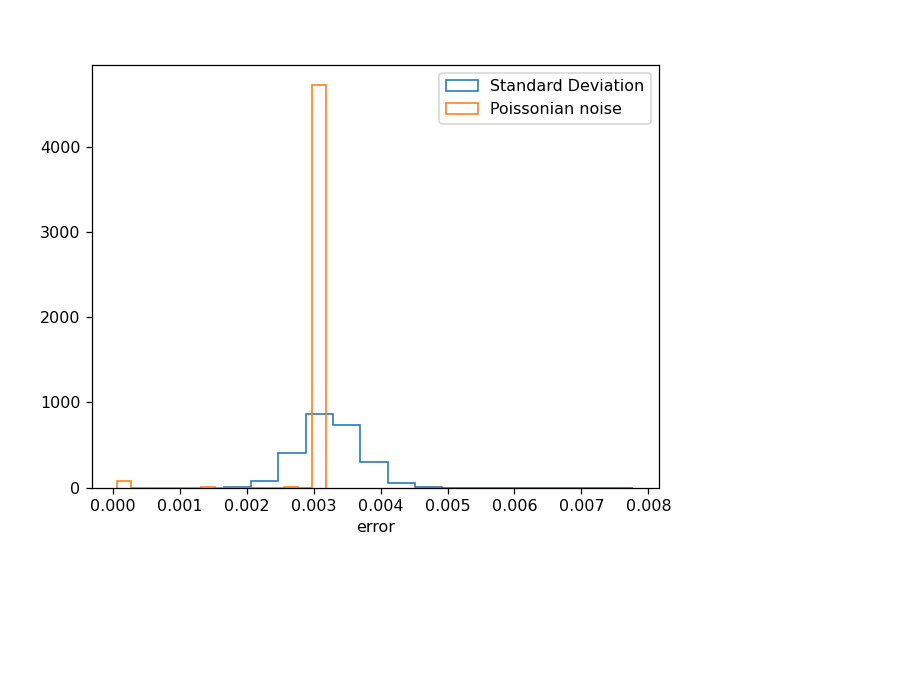

In [18]:
#Plotting this time with the correct median values for the rescaled flats.
STD_pixel = np.std(stack, axis=0)

plt.figure()
plt.hist(STD_pixel[:,100:500].flatten(),
         bins=15, density=True, histtype='step',
         label='Standard Deviation')

plt.hist(median_flat_err.flatten(),
         bins=15, density=True, histtype='step',
         label='Poissonian noise')

plt.legend()
plt.xlabel('error')
plt.show()

<IPython.core.display.Javascript object>


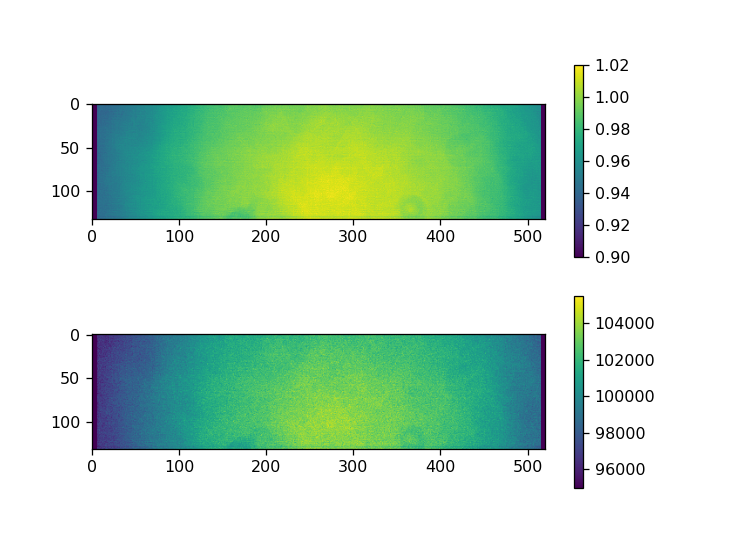

In [26]:
flat_fits = fits.open(flat_list[0])
flat_hdu = flat_fits[0]


fig, ax = plt.subplots(2,1)
im1 = ax[0].imshow(median_flat, vmin=0.9,vmax=1.02)
im2 = ax[1].imshow(flat_hdu.data * gain, vmin=9.5e4,vmax=10.55e4)
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])